In [1]:
import os

os.chdir("/home/sgsruan/UCL-gamma-ml/src")
print("Current working directory:", os.getcwd())

Current working directory: /home/sgsruan/UCL-gamma-ml/src


In [2]:
import data

In [3]:
root_dir = "/unix/erw/data/24-07-25/batch_output"
train_dataset, val_dataset, element_list, element_to_index = data.load_dataset(root_dir=root_dir, use_noise=True, val_ratio=0.2)

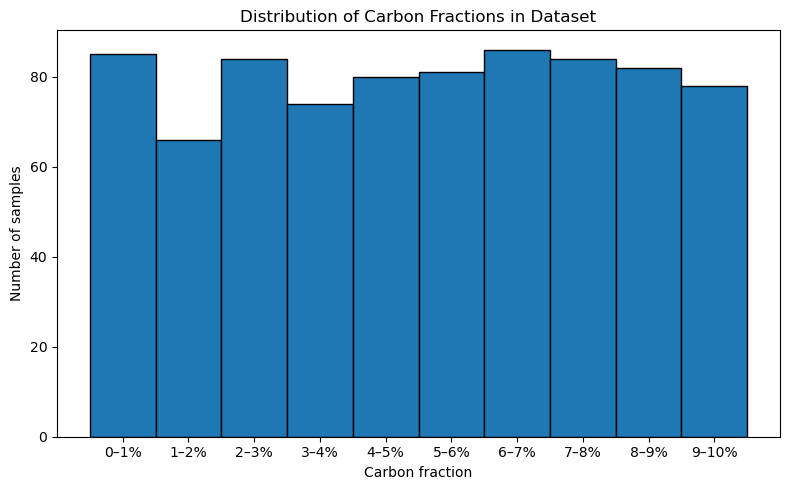

In [4]:
data.plot_carbon_fraction_histogram(train_dataset, element_to_index, bin_range='0-10')

In [5]:
import models
import losses

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


class CNN_MDN_no_softmax(nn.Module):
    """ 1d-CNN + MDN model """
    def __init__(self, num_elements=3, num_mixtures=3):
        super().__init__()
        self.num_elements = num_elements  # D -- dimension of target vector
        self.num_mixtures = num_mixtures  # M -- number of Gaussian mixture components

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=9, padding=4),   # [B, 64, e.g.: 1440 (comes from spectrum)]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),                  # [B, 32, 360]

            nn.Conv1d(64, 128, kernel_size=7, padding=3), # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 128, 180]
        )

        self.flatten_dim = 128 * 180  # update it if input structure changes

        self.hidden = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            #nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(),
            #nn.Dropout(0.3),
        )

        # Output heads:
        self.pi_layer = nn.Linear(64, num_mixtures)                    # [B, M]
        self.mu_layer = nn.Linear(64, num_mixtures * num_elements)     # [B, M*D]
        self.sigma_layer = nn.Linear(64, num_mixtures * num_elements)  # [B, M*D]

    def forward(self, x):
        B = x.size(0)
        x = self.conv_layers(x)
        x = x.view(B, -1)
        x = self.hidden(x)

        # Output parameters : pi, mu, sigma
        pi = F.softmax(self.pi_layer(x), dim=1)  # [B, M]

        mu = self.mu_layer(x).view(B, self.num_mixtures, self.num_elements)  # [B, M, D]
        #mu = F.softmax(mu, dim=2)  # fraction (0~1, sum=1)

        sigma = torch.exp(self.sigma_layer(x).view(B, self.num_mixtures, self.num_elements))  # [B, M, D]

        return pi, mu, sigma

In [75]:
# Hyperparameter (grid search in future)
batch_size = 32
epochs = 30
learning_rate = 1e-4

In [76]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [77]:
# Initialize model
model = CNN_MDN_no_softmax(num_elements=3, num_mixtures=3)  # now we get more mixture components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [78]:
def nomarlize_mu(mu):
    mu_sum = mu.sum(dim=-1, keepdim=True)
    mu_sum = mu_sum + 1e-8     # avoid divide-by-zero
    mu_normalized = mu / mu_sum
    return mu_normalized

Epoch 1/30 | Train Loss: 26.7088 | Val Loss: 29.5987
Epoch 2/30 | Train Loss: 9.4325 | Val Loss: 12.5984
Epoch 3/30 | Train Loss: 1.9754 | Val Loss: 1.2357
Epoch 4/30 | Train Loss: -1.2422 | Val Loss: -2.9462
Switching learning rate to 5e-5
Epoch 5/30 | Train Loss: -3.7119 | Val Loss: -4.0611
Epoch 6/30 | Train Loss: -4.8252 | Val Loss: -5.1147
Epoch 7/30 | Train Loss: -5.7432 | Val Loss: -6.4798
Epoch 8/30 | Train Loss: -6.9650 | Val Loss: -7.3455
Switching learning rate to 1e-5
Epoch 9/30 | Train Loss: -8.5319 | Val Loss: -8.7947
Switching learning rate to 5e-6
Epoch 10/30 | Train Loss: -9.1552 | Val Loss: -8.9941
Epoch 11/30 | Train Loss: -9.3164 | Val Loss: -9.0001
Epoch 12/30 | Train Loss: -9.5550 | Val Loss: -9.2788
Epoch 13/30 | Train Loss: -9.7063 | Val Loss: -9.3910
Epoch 14/30 | Train Loss: -9.5727 | Val Loss: -9.5148
Epoch 15/30 | Train Loss: -9.5875 | Val Loss: -9.5493
Epoch 16/30 | Train Loss: -9.7642 | Val Loss: -9.4795
Epoch 17/30 | Train Loss: -9.9809 | Val Loss: -9.663

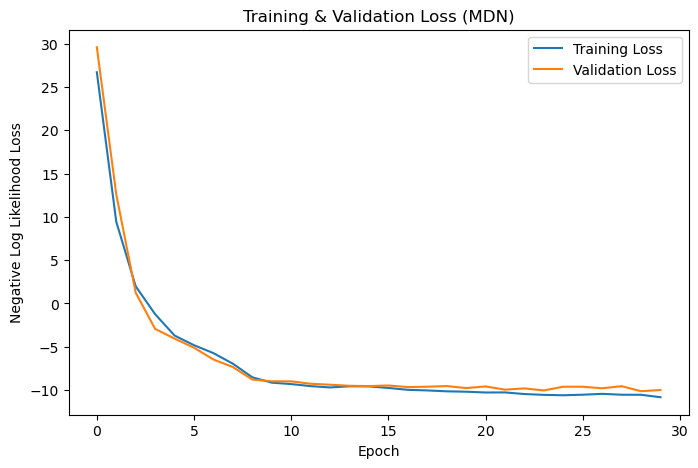

In [79]:
# Training loop
train_losses = []
val_losses = []

lr_switched_1 = False
lr_switched_2 = False
lr_switched_3 = False

gap_history = []
gap_window = 5
early_stop_triggered = False

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        pi, mu, sigma = model(batch_X)
        mu = nomarlize_mu(mu)
        #sample_weights = compute_asymmetric_sample_weights(batch_Y).to(device)
        loss = losses.mdn_loss_std(batch_Y, pi, mu, sigma, eps=1e-6)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X, val_Y = val_X.to(device), val_Y.to(device)
            pi, mu, sigma = model(val_X)
            mu = nomarlize_mu(mu)
            #sample_weights = compute_asymmetric_sample_weights(val_Y).to(device)
            loss = losses.mdn_loss_std(val_Y, pi, mu, sigma, eps=1e-6)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    gap = avg_val_loss - avg_train_loss
    gap_history.append(gap)

    if len(gap_history) > gap_window:
        gap_history.pop(0)  # only keep N recent gap value

        if epoch >= 20 and avg_val_loss <= -4:  
            # If N recent gap strictly increasing
            if all(gap_history[i] < gap_history[i + 1] for i in range(gap_window - 1)):
                print(f"Early stop at {gap_window} epochs")
                early_stop_triggered = True
                break
    
    # Switch learning rate
    if not lr_switched_1 and avg_train_loss < 1:
        print("Switching learning rate to 5e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 5e-5
        lr_switched_1 = True

    if not lr_switched_2 and avg_train_loss < -6:
        print("Switching learning rate to 1e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-5
        lr_switched_2 = True

    if not lr_switched_3 and avg_train_loss < -8:
        print("Switching learning rate to 5e-6")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 5e-6
        lr_switched_3 = True

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood Loss")
plt.title("Training & Validation Loss (MDN)")
plt.legend()
plt.show()

In [80]:
import evaluation
import utils

In [81]:
model.eval()

all_preds = []
all_targets = []
all_stds = []

all_pi = []
all_mu = []
all_sigma = []

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X = val_X.to(device)
        val_Y = val_Y.to(device)

        pi, mu, sigma = model(val_X)            # [B, M], [B, M, D], [B, M, D]
        mu = nomarlize_mu(mu)                   # normalization
        y_pred = utils.mdn_predict_mean(pi, mu)       # [B, D]
        y_std = utils.mdn_predict_std(pi, mu, sigma)  # [B, D]

        all_preds.append(y_pred.cpu())
        all_targets.append(val_Y.cpu())
        all_stds.append(y_std.cpu())

        all_pi.append(pi.cpu())
        all_mu.append(mu.cpu())
        all_sigma.append(sigma.cpu())


results = {
        "preds": torch.cat(all_preds, dim=0),
        "targets": torch.cat(all_targets, dim=0),
        "stds": torch.cat(all_stds, dim=0),
        "pi": torch.cat(all_pi, dim=0),
        "mu": torch.cat(all_mu, dim=0),
        "sigma": torch.cat(all_sigma, dim=0),
    }

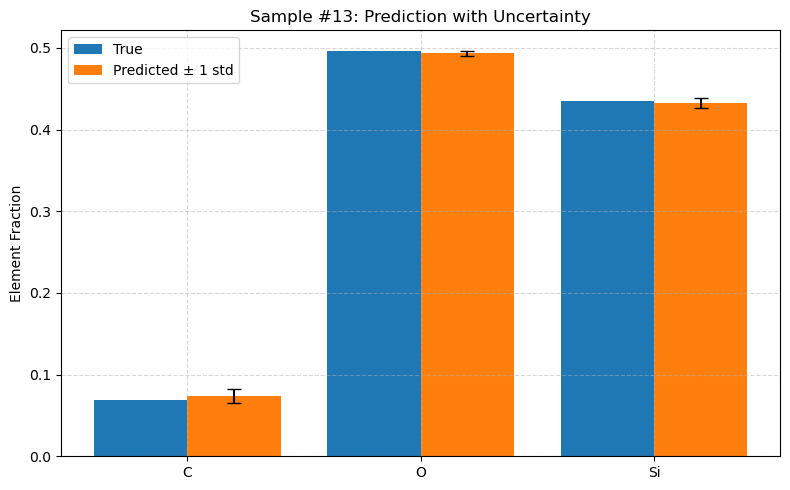

In [90]:
evaluation.plot_sample_with_uncertainty(results, element_list, sample_index=13)

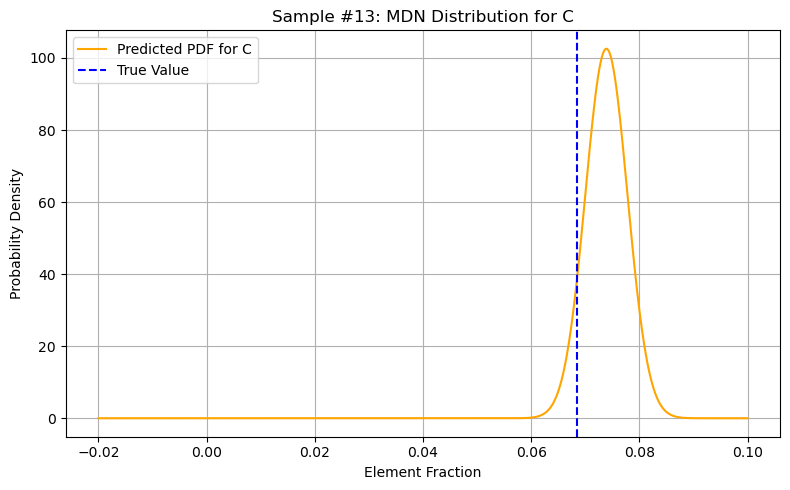

In [89]:
evaluation.plot_mdn_distribution(results, element_list, sample_index=13, element_name="C")

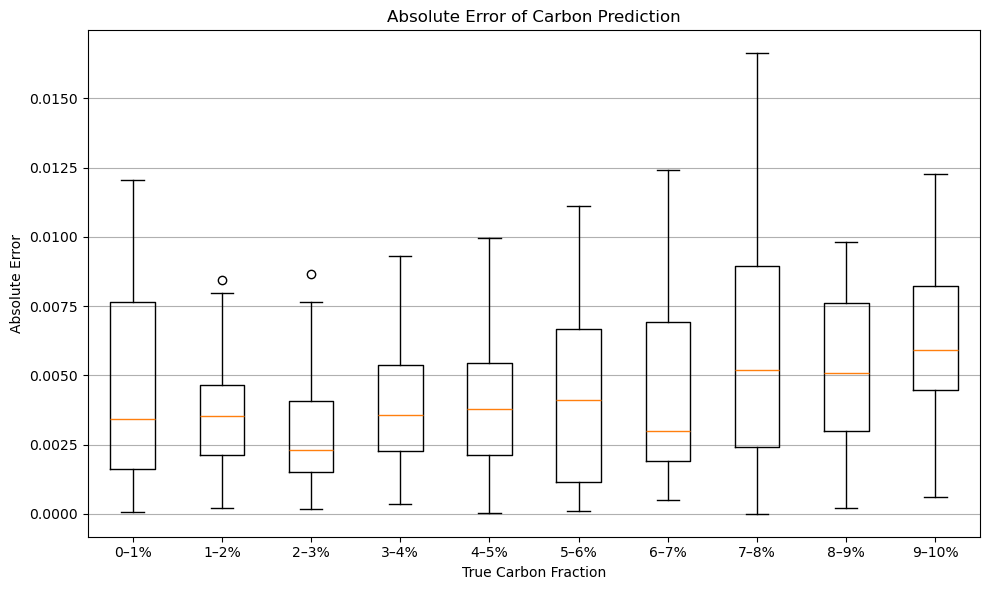

In [84]:
evaluation.plot_carbon_error_boxplot(results, element_to_index, bin_range="0-10")

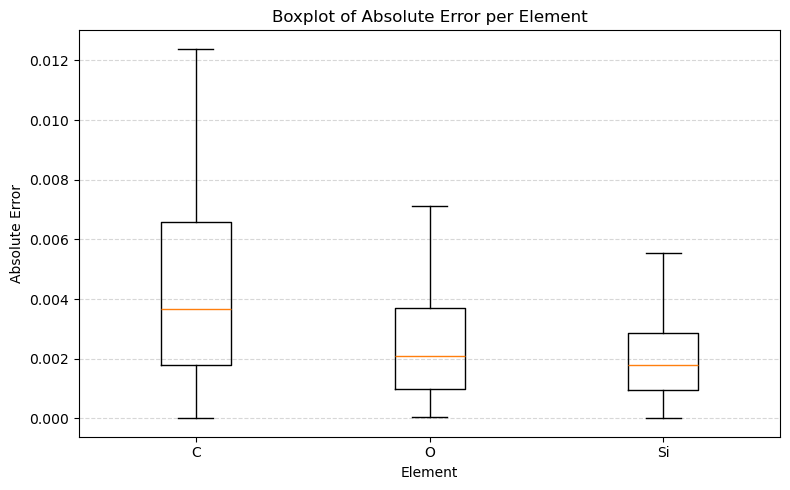

In [85]:
evaluation.plot_abs_error_boxplot(results, element_list)

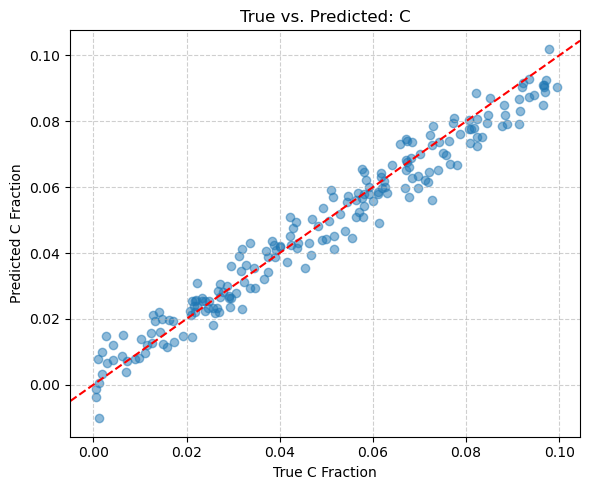

In [86]:
evaluation.plot_true_vs_pred_scatter(results, "C", element_to_index)

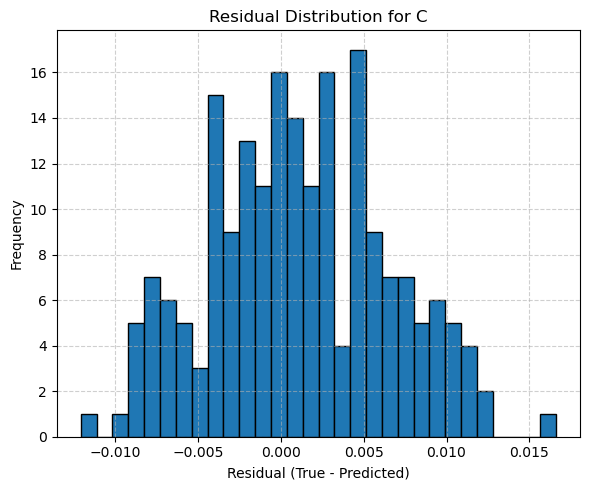

In [87]:
evaluation.plot_residual_histogram(results, "C", element_to_index, bins=30)

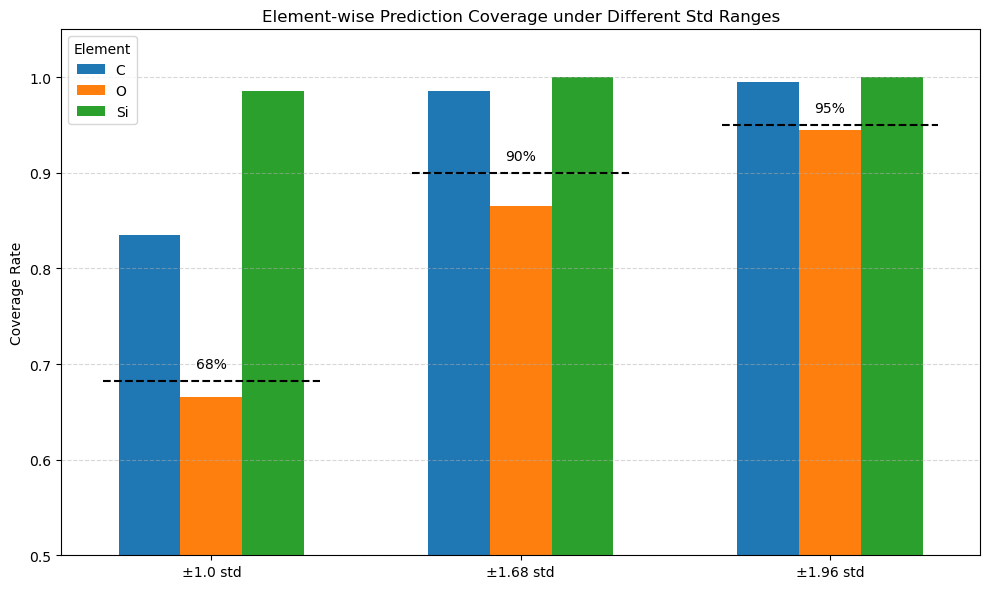

In [88]:
evaluation.plot_uncertainty_coverage(results, element_list, element_to_index)

In [21]:
#torch.save(model.state_dict(), "MDN_no_softmax.pt")